# How to define and measure a transfer function using the Moku:Pro PID Controller and Frequency Response Analyzer 

by Jason Ball
2025/03/17

## Section 1: Import and Connect

In [12]:
### First we make our standard Python imports ###
### These are not strictly necessary if you are not doing any manipulation or plotting of the data ###
import numpy as np
import matplotlib.pyplot as plt

In [14]:
### Now we make imports from the Moku package ###
### Import multi-instrument mode (MiM) plus all required instruments ###
from moku.instruments import MultiInstrument
from moku.instruments import PIDController
from moku.instruments import FrequencyResponseAnalyzer

In [16]:
### Establish connection to the Moku ###
### IP address will be different based on your setup ###
### Platform id will always be 1 or 4 for Moku Pro ###
mim = MultiInstrument('10.0.0.83', force_connect=True, platform_id=2)

### Retrieve the hardware version, serial number, and firmware version from the instrument ### 
idn = mim.serial_number()
prop = mim.describe()
print('Connected to ' + prop['hardware'] + ', S/N ' + idn)
print('Firmware version ' + str(prop['firmware']))

Connected to Moku:Go, S/N 004281
Firmware version 601.0


## Section 2: Configure FPGA

In [19]:
### Now we define our instruments ###
### Use the set instrument command and the instruments we imported earlier ###
### The number corresponds to the slot on the Moku:Pro FPGA ###
pid = mim.set_instrument(1, PIDController)
fra = mim.set_instrument(2, FrequencyResponseAnalyzer)

print('Instruments Set')

Instruments Set


In [21]:
### Define connection map ###
### The best way is to use a Python dictionary. Each connection has a source and destination. ###
### Slots are numbered 1-4, Inputs and Outputs are ordered A/B/C ###
### See the image below for reference ###

connections = [dict(source="Slot1OutA", destination="Slot2InA"),
               dict(source="Slot1OutB", destination="Slot2InB"),
               ]

mim.set_connections(connections=connections)

print('Connections Set')

Connections Set


## Section 3: Set up instruments

In [24]:
### Set up PID Controller ###

#Configures the control matrix:
# Channel 1: input 1 linear gain = 1 (0 dB), input 2 = 0 
# Channel 2: input 2 = 0, input 2 linear gain = 1
pid.set_control_matrix(channel=1, input_gain1=1, input_gain2=0)
pid.set_control_matrix(channel=2, input_gain1=0, input_gain2=1)

# Configure PID Control loop 1 using frequency response characteristics
#   P = -10dB
#   I Crossover = 100Hz
#   D Crossover = 10kHz
#   I Saturation = 10dB
#   D Saturation = 10dB
#   Double-I = OFF
pid.set_by_frequency(channel=1, prop_gain=-10, int_crossover=1e2,
                   diff_crossover=1e4, int_saturation=10,
                   diff_saturation=10)

# Configure PID Control loop 2 using gain
#   Proportional gain = 10
#   Differentiator gain = -5
#   Differentiator gain corner = 5 kHz
pid.set_by_gain(channel=2, overall_gain=-10, prop_gain=5, diff_gain=-40,
              diff_corner=1e3)

# Enable the outputs of the PID controller
pid.enable_output(1, signal=True, output=True)
pid.enable_output(2, signal=True, output=True)

print('PID Controller configured')
print(pid.summary()) 

PID Controller configured
Moku:Go PID Controller
Input A
Input B
Control matrix: 1-1 = 1, 1-2 = 0, 2-1 = 0, 2-2 = 1
Controller 1: PID controller: proportional gain -10.0 dB, integrator crossover 100.0 Hz, differentiator crossover 10.00 kHz, integrator saturation +10.0 dB, differentiator saturation +10.0 dB, input offset 0.000 0 V
Controller 2: advanced configuration, input offset 0.000 0 V
Section A: G = -10.0 dB, Kp = +5.0 dB, Kd = -40.0 dB, Dc = 1.000 kHz
Section B: off

Output A - control signal enabled, offset 0.000 0 V, limits disabled, output enabled
Output B - control signal enabled, offset 0.000 0 V, limits disabled, output enabled


In [30]:
### Set up Frequency Response Analyzer ### 
f_start = 1e6  # Hz
f_end = 10  # Hz
sweep_length = 512
amp_ch1 = 0.1  # Vpp
amp_ch2 = 0.1  # Vpp
averaging_time = 1e-6  # sec
settling_time = 1e-6  # sec
averaging_cycles = 1
settling_cycles = 1

# Set the output sweep amplitudes
fra.set_output(1, amp_ch1)
fra.set_output(2, amp_ch2)

# Set the sweep configuration
fra.set_sweep(start_frequency=f_start, stop_frequency=f_end,
            num_points=sweep_length, averaging_time=averaging_time,
            settling_time=settling_time, averaging_cycles=averaging_cycles,
            settling_cycles=settling_cycles)

# Start the output sweep in loop mode
fra.start_sweep()

{'estimated_sweep_time': 8.977271394399608}

## Section 4: Collect and plot results

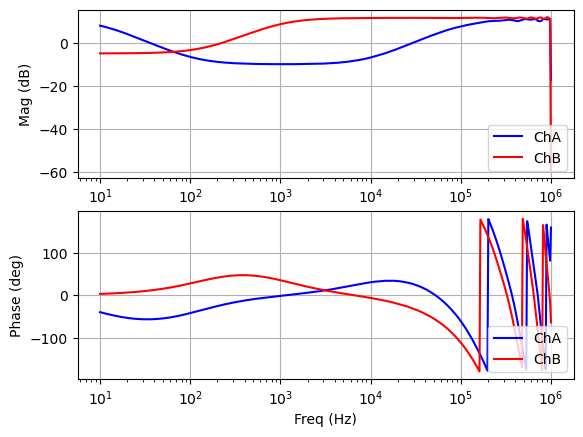

In [32]:
frame = fra.get_data(wait_complete=True, timeout=10)
ch1Data = frame['ch1']
ch2Data = frame['ch2']

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.semilogx(ch1Data['frequency'], ch1Data['magnitude'], 'b', label='ChA')
ax1.semilogx(ch2Data['frequency'], ch2Data['magnitude'], 'r', label='ChB')
ax1.grid(True)
ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Mag (dB)')
ax1.legend(loc='lower right')

ax2 = fig.add_subplot(212)
ax2.semilogx(ch1Data['frequency'], ch1Data['phase'], 'b', label='ChA')
ax2.semilogx(ch2Data['frequency'], ch2Data['phase'], 'r', label='ChB')
ax2.grid(True)
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (deg)')
ax2.legend(loc='lower right')

plt.show()